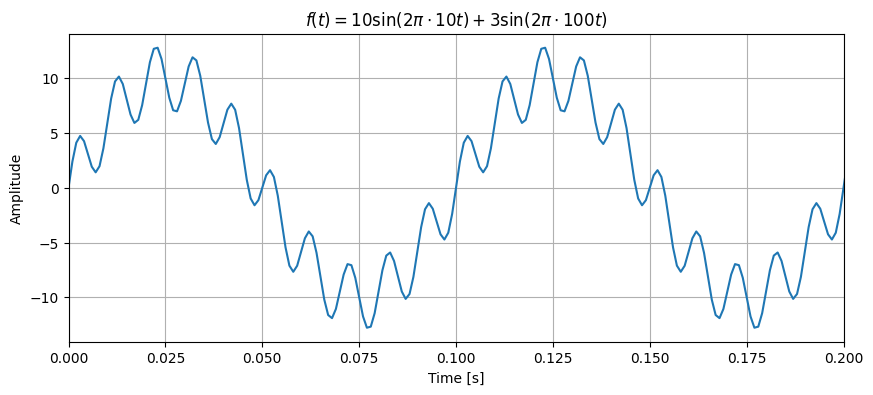

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 시간 축 정의
fs = 1000  # 샘플링 주파수 (Hz)
T = 1      # 전체 시간 (1초 동안 관찰)
N = int(fs*T) # 샘플의 개수
t = np.linspace(0, T, N, endpoint=False)

# 신호 정의
f = 10 * np.sin(2*np.pi*10*t) + 3 * np.sin(2*np.pi*100*t)

# 플로팅
plt.figure(figsize=(10, 4))
plt.plot(t, f)
plt.title(r'$f(t) = 10\sin(2\pi \cdot 10t) + 3\sin(2\pi \cdot 100t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 0.2)  # 처음 0.2초만 확대해서 보기 (고주파 성분 확인 용도)
plt.show()


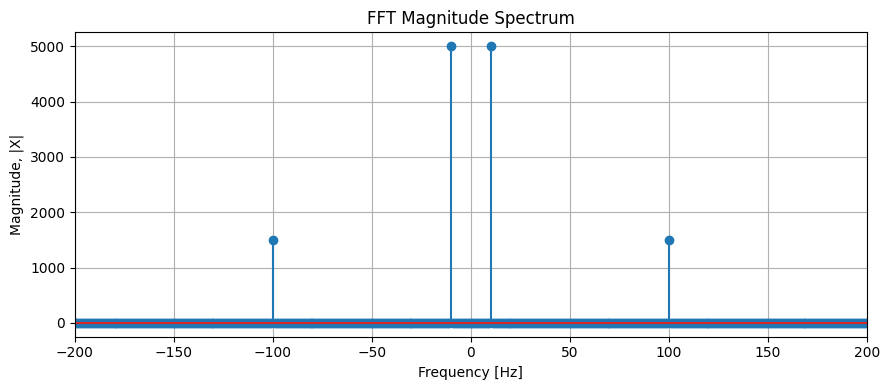

In [ ]:
X = np.fft.fft(f)
freqs = np.fft.fftfreq(N, d=1/fs)

plt.figure(figsize=(9, 4))
plt.stem(freqs, np.abs(X))
plt.title('FFT Magnitude Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude, |X|')
plt.grid(True)
plt.xlim(-200, 200)  # 관심 주파수 대역만 보기
plt.tight_layout()
plt.show()

In [ ]:
!wget https://mairlab-km.github.io/assets/courses/speech-audio-recognition-2025fall/materials/harvard.wav

--2025-09-19 07:24:30--  https://mairlab-km.github.io/assets/courses/speech-audio-recognition-2025fall/materials/harvard.wav
Resolving mairlab-km.github.io (mairlab-km.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to mairlab-km.github.io (mairlab-km.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3249924 (3.1M) [audio/wav]
Saving to: ‘harvard.wav’

harvard.wav         100%[===================>]   3.10M  --.-KB/s    in 0.07s   

2025-09-19 07:24:30 (46.8 MB/s) - ‘harvard.wav’ saved [3249924/3249924]



In [ ]:
!pip install librosa
!pip install pysoundfile

In [ ]:
import IPython
IPython.display.Audio('harvard.wav')

Output hidden; open in https://colab.research.google.com to view.

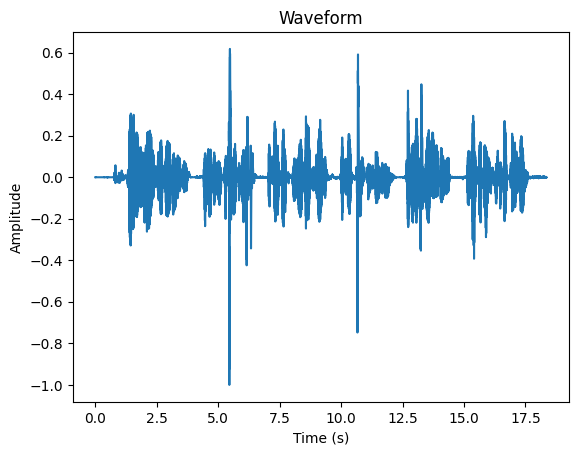

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

y, sr = librosa.load("harvard.wav")

time = np.linspace(0, len(y)/sr, num=len(y))

plt.figure()
plt.plot(time, y)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

In [ ]:
# Power 계산
power = np.mean(y**2)
print("Power:", power)

# RMS 계산
rms = np.sqrt(power)
print("RMS:", rms)

Power: 0.00314394
RMS: 0.056070846


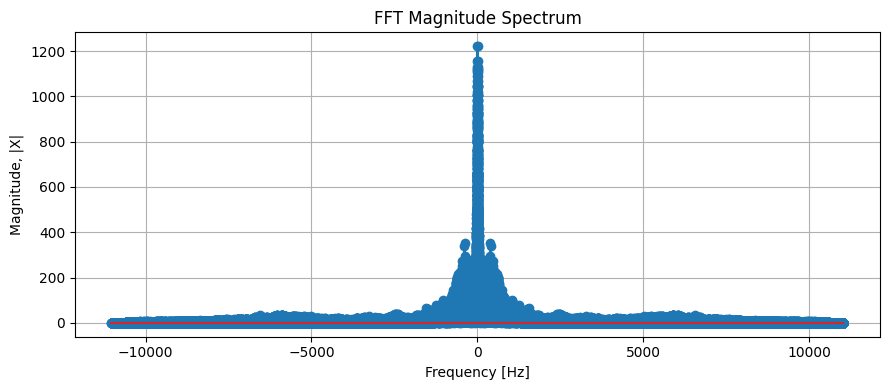

In [ ]:
y_freq = np.fft.fft(y)
freqs = np.fft.fftfreq(len(y), d=1/sr)

plt.figure(figsize=(9, 4))
plt.stem(freqs, np.abs(y_freq))
plt.title('FFT Magnitude Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude, |X|')
plt.grid(True)
plt.tight_layout()
plt.show()

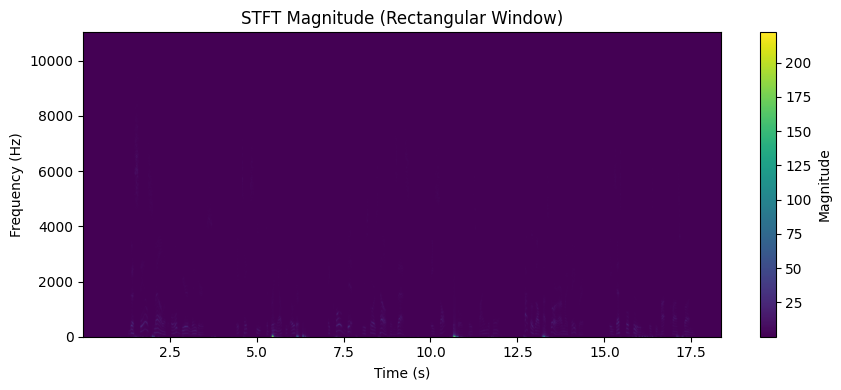

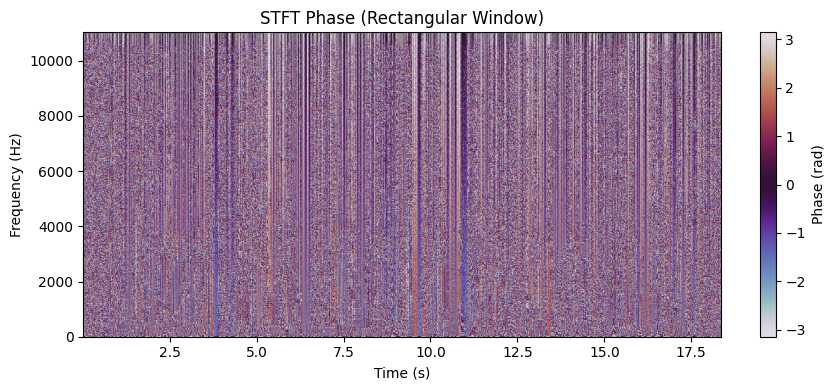

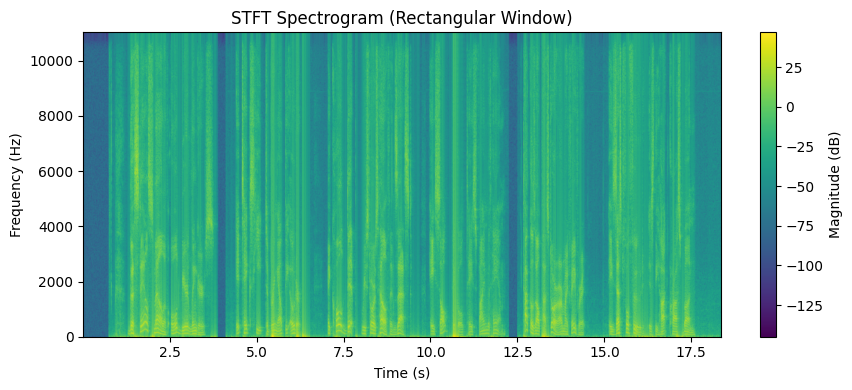

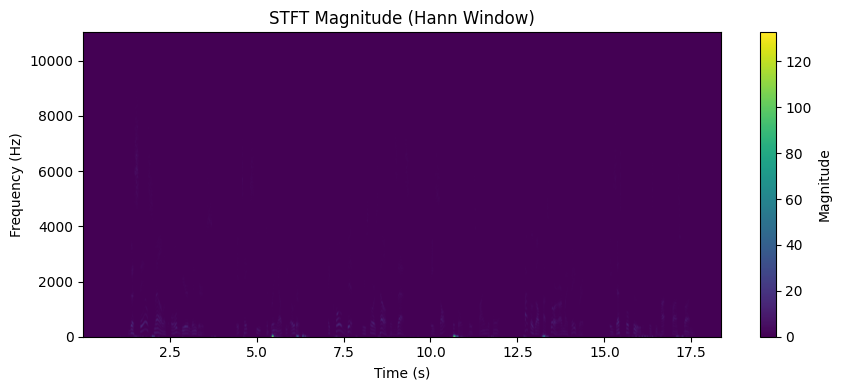

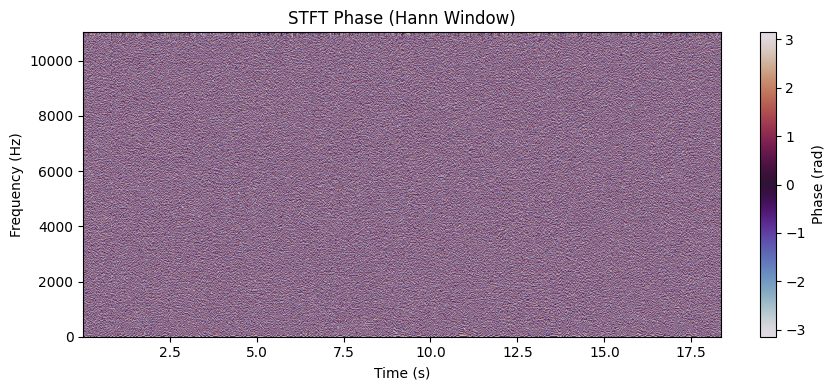

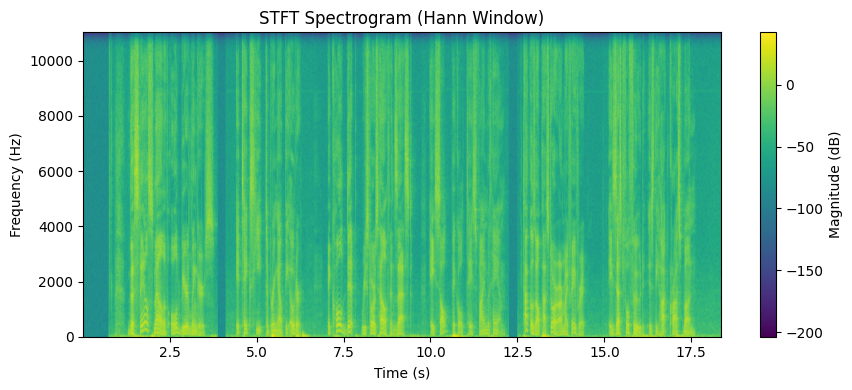

In [ ]:
def stft(signal, fs, frame_size, hop_size, window=None, n_fft=None):
    """
    Returns:
        mag: (freq_bins, n_frames) magnitude
        f:   frequency vector (Hz)
        tt:  time vector (s) for each frame center
    """
    N = len(signal)
    if n_fft is None:
        # next power of 2 >= frame_size
        n_fft = 1 << (frame_size - 1).bit_length()

    # number of frames (drop the tail that doesn't fit)
    n_frames = 1 + (N - frame_size) // hop_size

    # frame blocking via stride trick (no copying)
    frames = np.lib.stride_tricks.as_strided(
        signal,
        shape=(n_frames, frame_size),
        strides=(signal.strides[0] * hop_size, signal.strides[0]),
        writeable=False,
    )

    if window is None:
        windowed = frames  # rectangular (no tapering)
    else:
        windowed = frames * window[None, :]

    # rFFT for real signal
    X = np.fft.rfft(windowed, n=n_fft, axis=1)
    mag = np.abs(X).T  # (freq_bins, n_frames)
    phase = np.angle(X).T # (freq_bins, n_frames)
    f = np.fft.rfftfreq(n_fft, d=1 / fs)
    tt = (np.arange(n_frames) * hop_size + frame_size / 2) / fs
    return X.T, mag, phase, f, tt

def plot_spectrogram(mag, f, tt, title, fmax=None, cmap="viridis"):
    plt.figure(figsize=(9, 4))
    extent = [tt[0], tt[-1], f[0], f[-1]]
    plt.imshow(mag, origin="lower", aspect="auto", extent=extent, cmap=cmap)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    if fmax is not None:
        plt.ylim(0, fmax)
    plt.colorbar(label="Magnitude")
    plt.tight_layout()


def plot_phase(phase, f, tt, title, fmax=None, cmap="twilight"):
    plt.figure(figsize=(9, 4))
    extent = [tt[0], tt[-1], f[0], f[-1]]
    plt.imshow(phase, origin="lower", aspect="auto", extent=extent, cmap=cmap)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    if fmax is not None:
        plt.ylim(0, fmax)
    plt.colorbar(label="Phase (rad)")
    plt.tight_layout()

def plot_spectrogram_db(mag, f, tt, title, fmax=None):
    plt.figure(figsize=(9, 4))
    db = 20 * np.log10(mag + 1e-12)
    extent = [tt[0], tt[-1], f[0], f[-1]]
    plt.imshow(db, origin="lower", aspect="auto", extent=extent)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    if fmax is not None:
        plt.ylim(0, fmax)
    cbar = plt.colorbar()
    cbar.set_label("Magnitude (dB)")
    plt.tight_layout()

frame_size = 512
hop_size = 256
n_fft = 1024
fs = sr

# STFT WITHOUT window (rectangular)
y_freq_rec, mag_rec, phase_rec, f, tt = stft(y, fs, frame_size, hop_size, window=None, n_fft=n_fft)
plot_spectrogram(mag_rec, f, tt, "STFT Magnitude (Rectangular Window)")
plot_phase(phase_rec, f, tt, "STFT Phase (Rectangular Window)")
plot_spectrogram_db(mag_rec, f, tt, "STFT Spectrogram (Rectangular Window)")

# STFT WITH Hann window (for comparison)
hann = np.hanning(frame_size)
y_freq_hann, mag_hann, phase_hann, f2, tt2 = stft(y, fs, frame_size, hop_size, window=hann, n_fft=n_fft)

plot_spectrogram(mag_hann, f2, tt2, "STFT Magnitude (Hann Window)")
plot_phase(phase_hann, f2, tt2, "STFT Phase (Hann Window)")
plot_spectrogram_db(mag_hann, f2, tt2, "STFT Spectrogram (Hann Window)")

In [ ]:
np.max(mag_rec)
np.min(mag_rec)
np.mean(mag_rec)

np.float32(0.22712438)

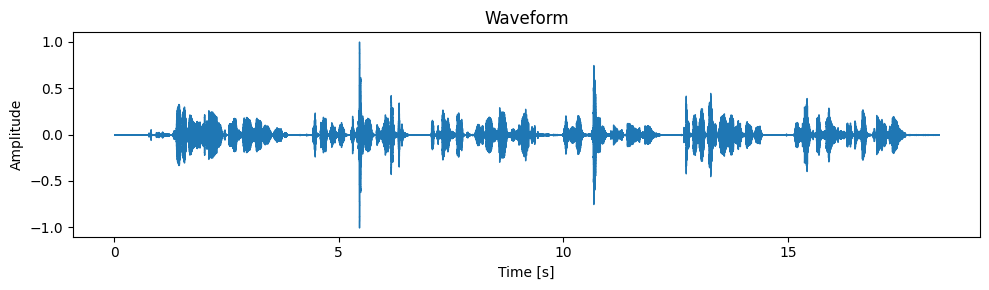

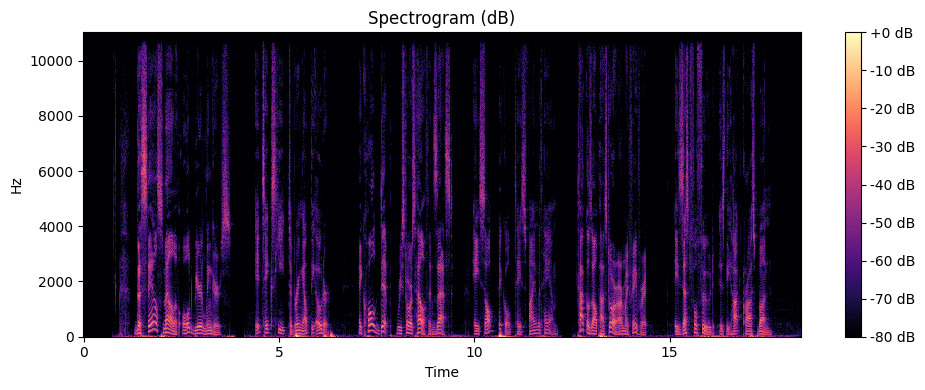

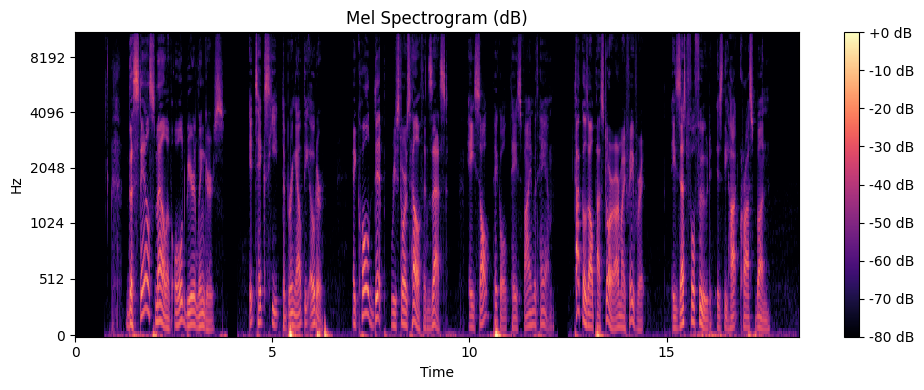

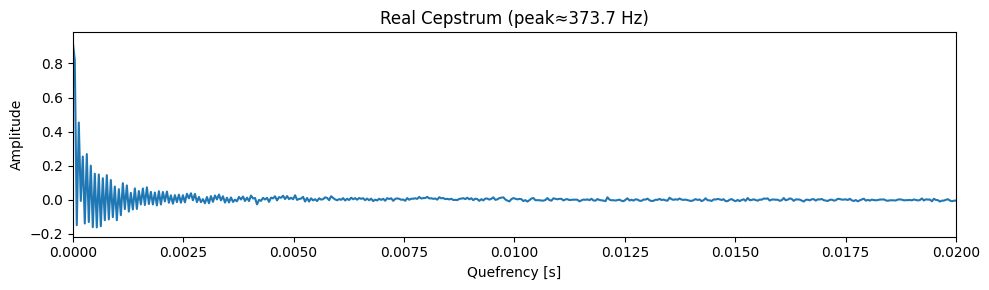

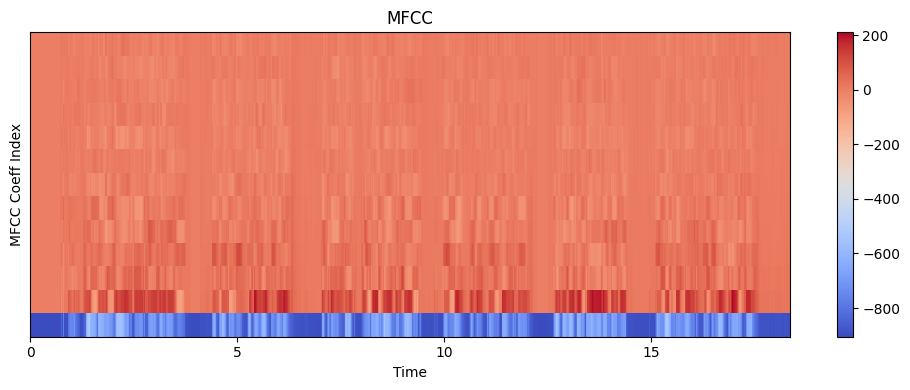

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft

n_fft = 2048
hop_length = 512
win_length = 1024
n_mels = 128
n_mfcc = 13

# ===== 2) Spectrogram (STFT) =====
S_complex = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window="hann", center=True)
S_mag = np.abs(S_complex)
S_db = librosa.amplitude_to_db(S_mag, ref=np.max)

# ===== 3) Mel Spectrogram =====
M = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                   win_length=win_length, n_mels=n_mels, window="hann", power=2.0)  # power=2 -> 파워 스펙트럼
M_db = librosa.power_to_db(M, ref=np.max)

# ===== 4) MFCC =====
mfcc = librosa.feature.mfcc(S=M_db, n_mfcc=n_mfcc)  # Mel-dB 스펙트로그램 기반

# ===== 5) Real Cepstrum (전신호 기준) =====
N = len(y)
Y = rfft(y * np.hanning(N))
log_mag = np.log(np.maximum(np.abs(Y), 1e-12))
cepstrum = irfft(log_mag)

# (선택) 피치 후보: 유의미한 quefrency 구간에서 최대값 찾기 (예: 50~400 Hz 범위)
fmin, fmax = 50.0, 400.0
qmin = int(sr / fmax)  # 최소 켑스트랄 랙(샘플)
qmax = int(sr / fmin)  # 최대 켑스트랄 랙(샘플)
q_range = cepstrum[qmin:qmax]
q_peak = qmin + np.argmax(q_range)
pitch_hz = sr / q_peak if q_peak > 0 else np.nan

# 6-1) Waveform
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# 6-2) Spectrogram (dB)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
plt.title("Spectrogram (dB)")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

# 6-3) Mel Spectrogram (dB)
plt.figure(figsize=(10, 4))
librosa.display.specshow(M_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel")
plt.title("Mel Spectrogram (dB)")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

# 6-4) Real Cepstrum (전체 신호)
quef = np.arange(len(cepstrum)) / sr
plt.figure(figsize=(10, 3))
plt.plot(quef, cepstrum)
plt.xlim(0, 0.02)
plt.title(f"Real Cepstrum (peak≈{pitch_hz:.1f} Hz)")
plt.xlabel("Quefrency [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# 6-5) MFCC (time × coeff)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis="time", sr=sr, hop_length=hop_length)
plt.title("MFCC")
plt.ylabel("MFCC Coeff Index")
plt.colorbar()
plt.tight_layout()
plt.show()